In [2]:
import h5py
from glob import glob
import numpy as np
from datetime import datetime

import pandas as pd
import xarray as xr

from dask import array as da
from dask import delayed

from iwaves.utils import isw

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

In [16]:
#%matplotlib notebook
%matplotlib inline

In [17]:
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'axes.labelsize':'large'})

In [47]:
# Load the converted data
#ds = xr.open_dataset('../../kdv_solutions_azure/kdv_all_ensembles.nc')
#ds = xr.open_dataset('../output/kdv_all_ensembles_magnus.nc')
#ds = xr.open_dataset('../output/kdv_magnus_x100km_v3.nc')
#ds = xr.open_dataset('../output/2019-07-03--06-58-08_magnus_kdv_runs.nc')
timetoday = 0.25

ds = xr.open_dataset('../output/2019-07-10--00-44-01_magnus_kdv_runs.nc')
timetoday = 1


ds

<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 373)
Coordinates:
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 365 366 367 368 369 370 371 372
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    amax      (ensemble, time) float64 ...
    tmax      (ensemble, time) float64 ...
    a0        (ensemble, time) float64 ...
    cn        (ensemble, time) float64 ...
    alpha     (ensemble, time) float64 ...
    beta      (time, ensemble, params) float64 ...
    ubed      (ensemble, time) float64 ...
    usurf     (ensemble, time) float64 ...

In [48]:
ds.amax.max(), ds.amax.min()

(<xarray.DataArray 'amax' ()>
 array(112.906574), <xarray.DataArray 'amax' ()>
 array(-109.427379))

In [49]:
amax_min = ds.amax.min(axis=0)
amax_max = ds.amax.max(axis=0)
amax_50 = np.mean(ds.amax, axis=0)


a0_min = ds.a0.min(axis=0)
a0_max = ds.a0.max(axis=0)
a0_50 = np.mean(ds.a0, axis=0)

# time
tmax = ds.tmax.values/(12.42*3600)
#tmax[tmax>3]=tmax[tmax>3]-1
tmax_min = tmax.min(axis=0)
tmax_max = tmax.max(axis=0)
tmax_50 = np.mean(tmax, axis=0)


alpha_min = ds.alpha.min(axis=0)
alpha_max = ds.alpha.max(axis=0)
alpha_50 = np.median(ds.alpha, axis=0)



In [77]:
T = 12.42*3600.
omega = 2*np.pi / T
#Ls = ds.cn**2. / (np.abs(ds.alpha)*ds.a0*omega) 
Ls = ds.cn**2. / (ds.alpha*ds.a0*omega) 

L = 1.0e5

Ls_min = np.abs(Ls).min(axis=0)
Ls_max = np.abs(Ls).max(axis=0)
Ls_50 = np.mean(np.abs(Ls), axis=0)

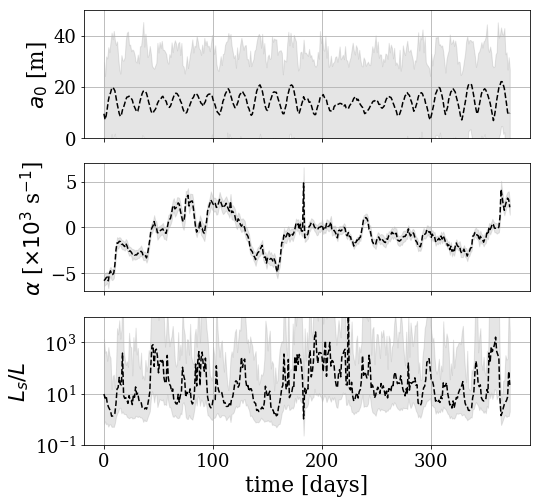

In [90]:
time = ds.time * timetoday

fig=plt.figure(figsize=(8,8))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
#plt.xlabel('time [days]')
ax1.set_xticklabels([])

plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_min*1000, alpha_max*1000, color='0.5',alpha=0.2)
plt.plot(time,alpha_50*1000,'k--', lw=1.5)
plt.ylabel(r'$\alpha$ [$\times 10^3$ s$^{-1}$]')
plt.ylim(-7,7)
ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)

ax3=plt.subplot(313)
plt.fill_between(time, Ls_min/L, Ls_max/L, color='0.5',alpha=0.2)
plt.plot(time,Ls_50/L,'k--', lw=1.5)

plt.ylabel('$L_s/L$')
plt.xlabel('time [days]')
ax3.set_yscale('log')
plt.grid(b=True)
plt.ylim(0.1,1e4)


#plt.savefig('../FIGURES/kdv_12month_a0_A.png',dpi=150)
plt.show()

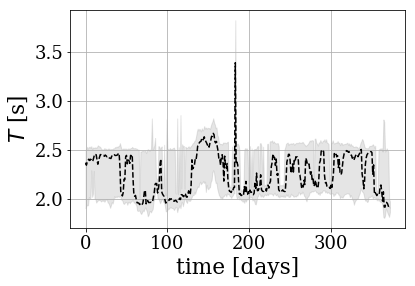

In [63]:
#plot the time
plt.figure()
plt.fill_between(time, tmax_min, tmax_max, color='0.5',alpha=0.2)
plt.plot(time,tmax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$T$ [s]')
plt.xlabel('time [days]')
plt.grid(b=True)

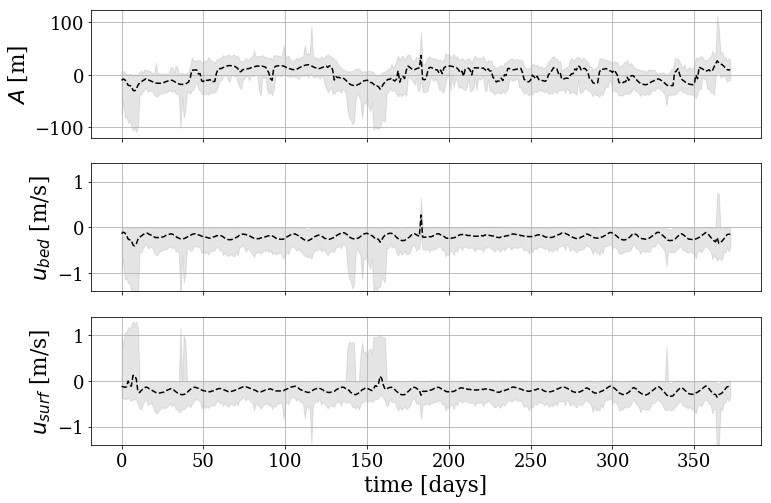

In [91]:

ubed_min = ds.ubed.min(axis=0)
ubed_max = ds.ubed.max(axis=0)
ubed_50 = np.mean(ds.ubed, axis=0)


usurf_min = ds.usurf.min(axis=0)
usurf_max = ds.usurf.max(axis=0)
usurf_50 = np.mean(ds.usurf, axis=0)

plt.figure(figsize=(12,8))

ax1=plt.subplot(311)
plt.fill_between(time, amax_min, amax_max, color='0.5',alpha=0.2)
plt.plot(time,amax_50,'k--', lw=1.5)

#plt.xlim(200,300)
plt.ylabel('$A$ [m]')
plt.grid(b=True)
ax1.set_xticklabels([])

ax2=plt.subplot(312)
plt.fill_between(time, ubed_min, ubed_max, color='0.5',alpha=0.2)
plt.plot(time,ubed_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{bed}$ [m/s]')
plt.ylim(-1.4,1.4)
#plt.xlabel('time [days]')
plt.grid(b=True)
ax2.set_xticklabels([])


ax3= plt.subplot(313)
plt.fill_between(time, usurf_min, usurf_max, color='0.5',alpha=0.2)
plt.plot(time,usurf_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$u_{surf}$ [m/s]')
plt.ylim(-1.4,1.4)

plt.xlabel('time [days]')
plt.grid(b=True)



#plt.savefig('../FIGURES/kdv_12month_velocity.png',dpi=150)
plt.show()

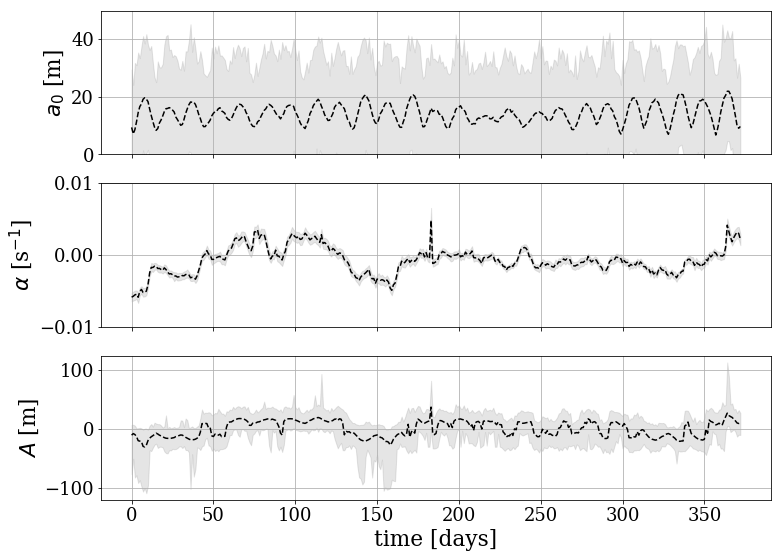

In [65]:




plt.figure(figsize=(12,9))
ax1=plt.subplot(311)
plt.fill_between(time, a0_min, a0_max, color='0.5',alpha=0.2)
plt.plot(time,a0_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel('$a_0$ [m]')
plt.ylim(0,50)
ax1.set_xticklabels([])

#plt.xlabel('time [days]')
plt.grid(b=True)

ax2=plt.subplot(312)
plt.fill_between(time, alpha_min, alpha_max, color='0.5',alpha=0.2)
plt.plot(time,alpha_50,'k--', lw=1.5)
#plt.xlim(200,300)
plt.ylabel(r'$\alpha$ [s$^{-1}$]')
plt.ylim(-0.01,0.01)
ax2.set_xticklabels([])
#plt.xlabel('time [days]')
plt.grid(b=True)



#plt.savefig('../FIGURES/kdv_12month_a0_A_alpha.png',dpi=150)

plt.show()

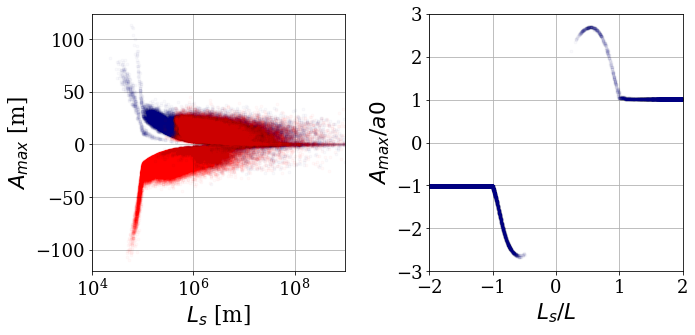

In [92]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.semilogx(Ls, ds.amax, '.', color='navy', alpha=0.02)
plt.semilogx(-Ls, ds.amax, '.', color='red', alpha=0.02)

plt.xlim(1e4,1e9)
#plt.ylim(-4,4)
plt.grid(b=True)

plt.ylabel(r'$A_{max}$ [m]')
plt.xlabel('$L_s$ [m]')

plt.subplot(122)
plt.plot(Ls/L, ds.amax/ds.a0, '.', color='navy', alpha=0.02)
plt.xlim(-2.0,2.0)
plt.ylim(-3,3)
#plt.xticks([-2.0,-1.5,-1.0,-0.5,0,0.5,1.,1.5,2.])
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')


plt.tight_layout()

#plt.savefig('../FIGURES/kdv_Amax_vs_Ls.png',dpi=150)


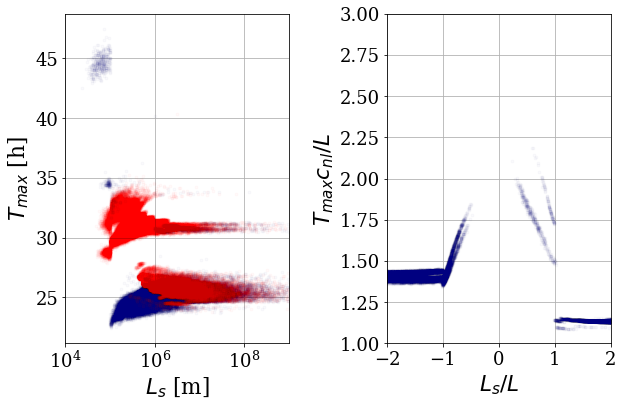

In [112]:
plt.figure(figsize=(9,6))

plt.subplot(121)
plt.semilogx(Ls, tmax*T/3600., '.', color='navy', alpha=0.02)
plt.semilogx(-Ls, tmax*T/3600., '.', color='red', alpha=0.02)

#plt.semilogx(Ls, ds.tmax*ds.cn/L, '.', color='navy', alpha=0.02)

plt.xlim(1e4,1e9)
#plt.ylim(1,4)
plt.grid(b=True)

plt.ylabel(r'$T_{max}$ [h]')
plt.xlabel('$L_s$ [m]')

plt.subplot(122)
c_nl = ds.cn + ds.amax*ds.alpha
plt.plot(Ls/L, tmax*T*c_nl/L, '.', color='navy', alpha=0.02)
#plt.plot(ds.amax*ds.alpha/ds.cn, tmax*T*ds.cn/L, '.', color='navy', alpha=0.02)


#plt.semilogx(Ls/L, ds.amax/ds.a0, '.', color='navy', alpha=0.02)
plt.xlim(-2,2)
plt.ylim(1,3)
plt.grid(b=True)

plt.ylabel(r'$T_{max}c_{nl}/L$')
plt.xlabel('$L_s / L$')


plt.tight_layout()

#plt.savefig('../FIGURES/kdv_Amax_vs_Ls.png',dpi=150)

In [108]:
# Plot with the parametric forms overlaid

def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1


    return Ahat

Lhat = np.linspace(-2,2,500)
Ahat_g = calc_Ahat_quadratic(Lhat,(-2.68,-0.54))
That_g = calc_That_quadratic(Lhat,(1.95,1.4,-0.1))

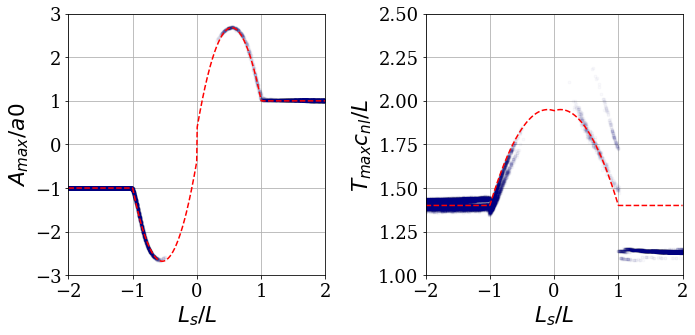

In [114]:
plt.figure(figsize=(10,5))

plt.subplot(121)

plt.plot(Ls/L, ds.amax/ds.a0, '.', color='navy', alpha=0.02)
plt.plot(Lhat, Ahat_g,'r--')

plt.xlim(-2.0,2.0)
plt.ylim(-3,3)
plt.grid(b=True)

plt.ylabel(r'$A_{max}/a0$')
plt.xlabel('$L_s / L$')

plt.subplot(122)
plt.plot(Ls/L, tmax*T*c_nl/L, '.', color='navy', alpha=0.02)
plt.plot(Lhat, That_g,'r--')
plt.xlim(-2,2)
plt.ylim(1,2.5)
plt.grid(b=True)

plt.ylabel(r'$T_{max}c_{nl}/L$')
plt.xlabel('$L_s / L$')

plt.tight_layout()

plt.savefig('../FIGURES/kdv_Amax_Tamax_parametric.png',dpi=150)
plt.savefig('../FIGURES/kdv_Amax_Tamax_parametric.pdf',dpi=150)